## Load modules

In [360]:
import pylab
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from scipy.stats import norm

from tqdm.notebook import tqdm

## Load data

In [361]:
imdb_rt = pd.read_csv('imdb_rt.csv')
imdb_rt

,title,netflix,hulu,prime,disney,runtime,num_votes,rt_rating,drama,biography,...,thriller,action,talk-show,news,comedy,fantasy,war,reality-tv,romance,imdb_rating
0,thepatchworkgirlofoz1914,0,0,1,0,81,493,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.5
1,thecheat1915,0,0,1,0,59,2581,5.2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.5
2,fanchonthecricket1915,0,0,1,0,75,215,4.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.5
3,joanthewoman1916,0,0,1,0,138,590,4.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4
4,themarkofzorro1920,0,0,1,0,79,2545,5.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5830,bulletproof22020,1,0,0,0,97,624,4.7,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5
5831,thesestreetswehaunt2021,0,0,1,0,107,146,4.6,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.1
5832,brighthillroad2020,0,0,1,0,91,318,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4
5833,coffeekareem2020,1,0,0,0,88,13740,5.1,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.1


## Exploratory Analysis

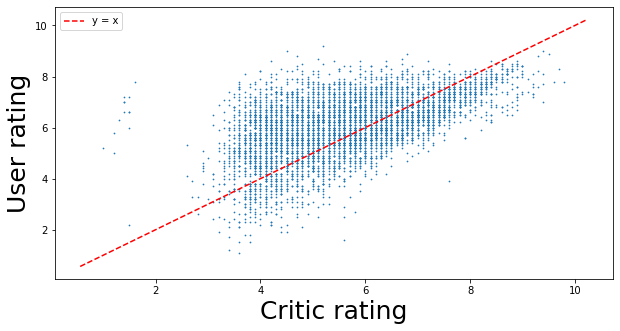

In [364]:
plt.figure(figsize = (10, 5))

#Plot the rotten tomatoes critic rating versus the IMDB user rating
plt.scatter(imdb_rt['rt_rating'], imdb_rt['imdb_rating'], s = 0.5)

# y = x line
x_vals = np.array(plt.gca().get_xlim())
plt.plot(x_vals, x_vals, '--', color = 'red', label = 'y = x')
plt.xlabel('Critic rating', fontsize = 25)
plt.ylabel('User rating', fontsize = 25)

plt.legend()
plt.show()

# Looks pretty linear

In [417]:
# Some films dont have runtime info, lets set those to the average runtime
runrat = np.vstack((np.array(imdb_rt['runtime']), np.array(imdb_rt['imdb_rating']))).T
runrat

array([['81', 5.5],
       ['59', 6.5],
       ['75', 6.5],
       ...,
       ['91', 4.4],
       ['88', 5.1],
       ['97', 7.0]], dtype=object)

In [418]:
#Extract the non NAs
na_idcs = np.where(runrat[:, 0] == '\\N') 
mask = np.ones(runrat.shape[0], dtype = bool)
mask[na_idcs] = False
runrat_ = runrat[mask, :]
runrat_ = runrat[mask]

In [419]:
# Replace the NAs with the mean runtime
runrat_ = runrat_.astype(float)
runrat[na_idcs, 0] = runrat_[:, 0].mean()

runrat = runrat.astype(float)

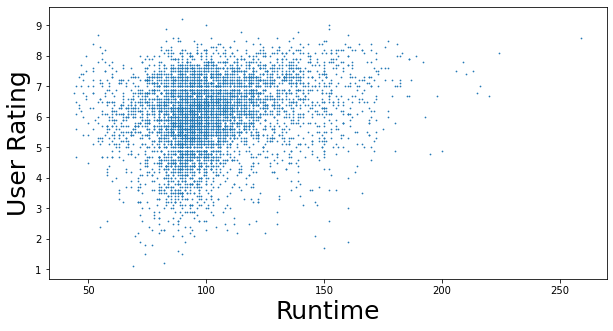

In [440]:
plt.figure(figsize = (10, 5))

# Plot the runtime against the ratings
plt.scatter(runrat[:, 0], runrat[:, 1], s = 0.5)
plt.xlabel('Runtime', fontsize = 25)
plt.ylabel('User Rating', fontsize = 25)
plt.show()

# No very obvious relationship  here

In [441]:
# Make sure to replace pandas column with new interpolated data
imdb_rt['runtime'] = runrat[:, 0]
imdb_rt

,title,netflix,hulu,prime,disney,runtime,num_votes,rt_rating,drama,biography,...,thriller,action,talk-show,news,comedy,fantasy,war,reality-tv,romance,imdb_rating
0,thepatchworkgirlofoz1914,0,0,1,0,81.0,493,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.5
1,thecheat1915,0,0,1,0,59.0,2581,5.2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.5
2,fanchonthecricket1915,0,0,1,0,75.0,215,4.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.5
3,joanthewoman1916,0,0,1,0,138.0,590,4.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4
4,themarkofzorro1920,0,0,1,0,79.0,2545,5.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5830,bulletproof22020,1,0,0,0,97.0,624,4.7,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5
5831,thesestreetswehaunt2021,0,0,1,0,107.0,146,4.6,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.1
5832,brighthillroad2020,0,0,1,0,91.0,318,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4
5833,coffeekareem2020,1,0,0,0,88.0,13740,5.1,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.1


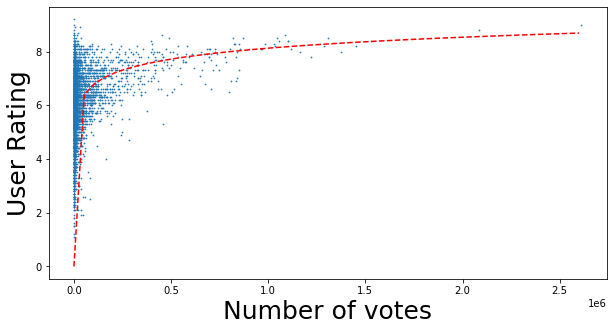

In [442]:
plt.figure(figsize = (10, 5))

# Plot the number of votes against the ratings
plt.scatter(imdb_rt['num_votes'], imdb_rt['imdb_rating'], s = 0.5)
x_vals = np.linspace(1, 2600000)
plt.plot(x_vals, 1/1.7 * np.log(x_vals), '--', color = 'red')
plt.xlabel('Number of votes', fontsize = 25)
plt.ylabel('User Rating', fontsize = 25)
plt.show()

# No very obvious relationship  here, plausibly some non-linear one

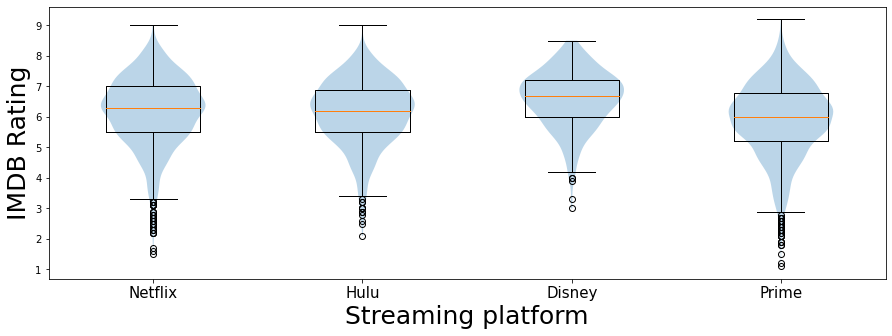

In [443]:
# Subset just those films that appear on each streaming platform
netflix = imdb_rt[imdb_rt['netflix'] == 1]['imdb_rating']
hulu = imdb_rt[imdb_rt['hulu'] == 1]['imdb_rating']
disney = imdb_rt[imdb_rt['disney'] == 1]['imdb_rating']
prime = imdb_rt[imdb_rt['prime'] == 1]['imdb_rating']

columns = [netflix, hulu, disney, prime]

fig, ax = plt.subplots(figsize = (15, 5))
ax.violinplot(columns, showmedians = False, showextrema = False)
ax.boxplot(columns)
plt.xticks([1, 2, 3, 4], ["Netflix", "Hulu", "Disney", "Prime"], fontsize = 15)
plt.xlabel('Streaming platform', fontsize = 25)
plt.ylabel('IMDB Rating', fontsize = 25)
plt.show()

# Not a lot of separation here, but the kdes do look fairly different, different tails, modes in different areas

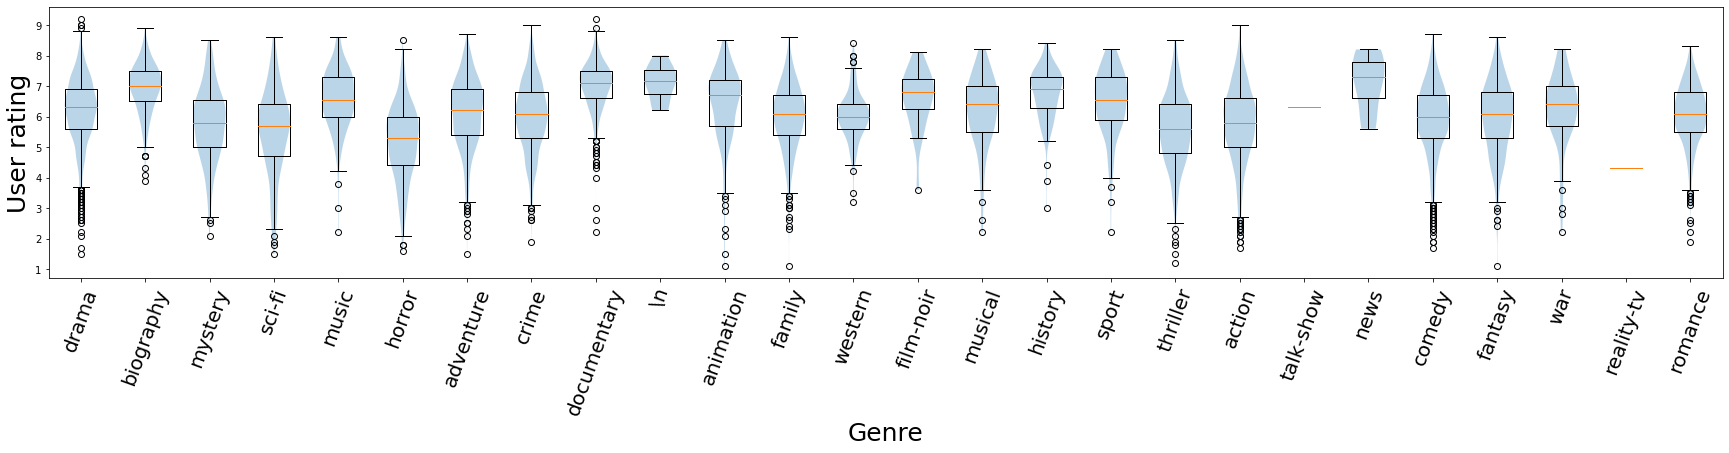

In [444]:
# Subset just those films that appear in each genre
genres = imdb_rt.columns.to_numpy()[8:-1]
columns = {}
for genre in genres:
    columns[genre] = imdb_rt[imdb_rt[genre] == 1]['imdb_rating'].to_numpy()

fig, ax = plt.subplots(figsize = (30, 5))
ax.violinplot(list(columns.values()), showmedians = False, showextrema = False)
ax.boxplot(list(columns.values()))
    
plt.xticks(list(range(1, len(columns) + 1)), list(columns.keys()), rotation = 70, fontsize = 20)
plt.xlabel('Genre', fontsize = 25)
plt.ylabel('User rating', fontsize = 25)
plt.show()

# Quite a lot of separation here, genre could be quite predictive
# Note that '/n' indicates there has been no genre set by IMDB

## Model selection

In [445]:
X = imdb_rt.iloc[:, 1:-1].to_numpy()
X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [446]:
y = imdb_rt['imdb_rating'].to_numpy().reshape(-1, 1)
y

array([[5.5],
       [6.5],
       [6.5],
       ...,
       [4.4],
       [5.1],
       [7. ]])

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

### Linear regression

In [511]:
# Lets fit a linear regression model as a baseline
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [512]:
# Okay R squared, might be worth thinking about extracting/finding more meaningful features
lr.score(X_test, y_test)

0.4867978157248314

In [513]:
y_pred_lr = lr.predict(X_test)

In [514]:
np.abs(y_test - y_pred_lr).mean()

0.6307484799232955

In [515]:
((y_test - y_pred_lr)**2).mean()

0.6947764976739216

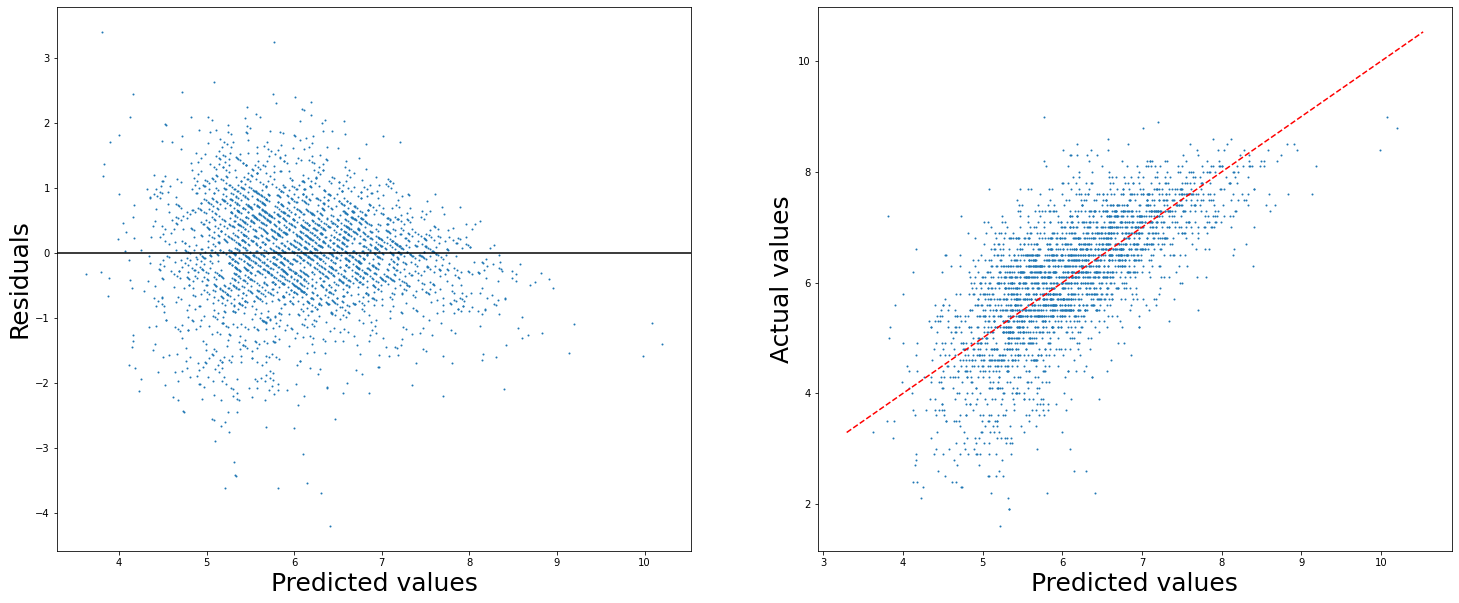

In [516]:
lr_residuals = y_test - y_pred_lr

fig, axs = plt.subplots(1, 2, figsize = (25, 10))
axs[0].scatter(y_pred_lr, lr_residuals, s = 1)
axs[0].axhline(y = 0, color = 'black')
axs[0].set_ylabel('Residuals', fontsize = 25)
axs[0].set_xlabel('Predicted values', fontsize = 25)

axs[1].scatter(y_pred_lr, y_test, s = 1)
# y = x line
x_vals = np.array(plt.gca().get_xlim())
axs[1].plot(x_vals, x_vals, '--', color = 'red', label = 'y = x')
axs[1].set_ylabel('Actual values', fontsize = 25)
axs[1].set_xlabel('Predicted values', fontsize = 25)

plt.show()

# Residuals seem mostly centred around 0, some heteroskedasticity, possibly a small non-linear relationship.
# Over predicting at low values.

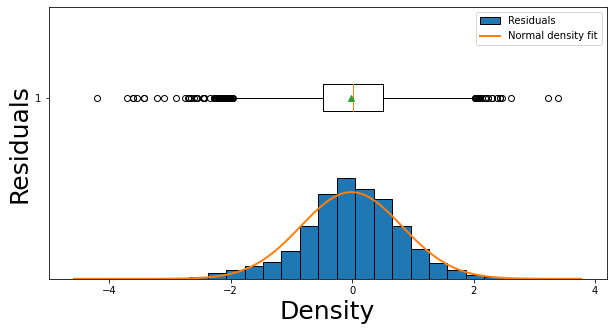

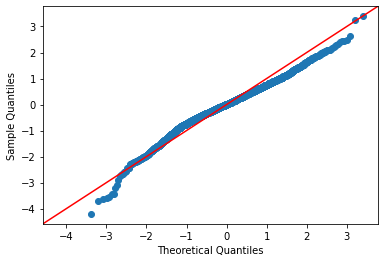

In [517]:
plt.figure(figsize = (10, 5))

plt.hist(lr_residuals, bins = 25, ec = 'black', density = True, label = 'Residuals')

x_lims = np.array(plt.gca().get_xlim())
x = np.linspace(x_lims[0], x_lims[1], 100)
p = norm.pdf(x, lr_residuals.mean(), lr_residuals.std())
plt.plot(x, p, linewidth = 2, label = 'Normal density fit')

plt.boxplot(lr_residuals, vert = False, showmeans = True, showcaps = False)

plt.ylabel('Residuals', fontsize = 25)
plt.xlabel('Density', fontsize = 25)

plt.legend()
plt.show()

sm.qqplot(lr_residuals.reshape(-1), line='45')
pylab.show()

# Slight left skew and heavy tails. 
# The linear model does seem to perform well, though there is some limited evidence a more flexible model
# could perform well.

### Kernel Ridge Regression

In [505]:
min_alpha = 0.4
max_alpha = 10
num_alphas = 50
alphas = np.unique(np.logspace(np.log10(min_alpha), np.log10(max_alpha), num_alphas))

ae = np.zeros(alphas.shape[0])
mse = np.zeros(alphas.shape[0])

In [506]:
for i in tqdm(range(alphas.shape[0])):
    krr = KernelRidge(kernel = 'linear', alpha = alphas[i]).fit(X_train, y_train)
    y_pred_krr = krr.predict(X_test)
    y_pred_krr[y_pred_krr < 0] = 0
    y_pred_krr[y_pred_krr > 10] = 10
    ae[i] = np.abs(y_test - y_pred_krr).mean()
    mse[i] = ((y_test - y_pred_krr)**2).mean()

  0%|          | 0/50 [00:00<?, ?it/s]

/home/tt21864/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.84487e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/tt21864/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.4491e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/tt21864/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.00932e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/tt21864/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.07822e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


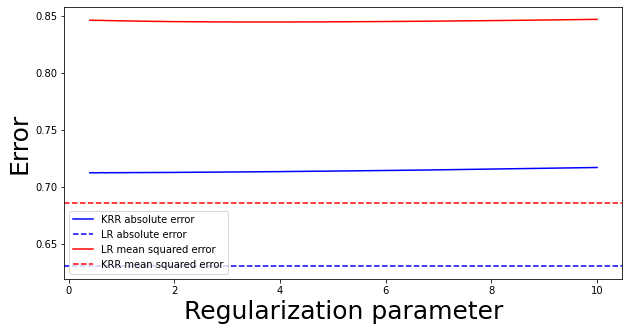

In [50]:
plt.figure(figsize = (10, 5))
plt.plot(alphas, ae, color = 'blue', label = 'KRR absolute error')
plt.axhline(np.abs(y_test - y_pred_lr).mean(),  color = 'blue', label = 'LR absolute error', linestyle = '--')
plt.plot(alphas, mse, color = 'red', label = 'LR mean squared error')
plt.axhline(((y_test - y_pred_lr)**2).mean(),  color = 'red', label = 'KRR mean squared error', linestyle = '--')
plt.legend()
plt.xlabel('Regularization parameter', fontsize = 25)
plt.ylabel('Error', fontsize = 25)
plt.show()

# Appears like linear regression is strictly better here, other kernels show no improvement

### Polynomial Regression

In [518]:
# Lets try polynomial regression with a quadratic basis. Other bases don't perform better
pr = Pipeline([
    ('poly', PolynomialFeatures(degree = 2)),
    ('linear', LinearRegression())
])

In [519]:
pr.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression())])

In [520]:
# Terrible R squared with the new features on this split
# We seem to be doing arbitrarily badly here
pr.score(X_test, y_test)

-37.654897114419335

In [521]:
y_pred_pr = pr.predict(X_test)

In [522]:
np.abs(y_test - y_pred_pr).mean()

0.7802651117370304

In [523]:
((y_test - y_pred_pr)**2).mean()

# Lets analyse the residuals

52.33125434380873

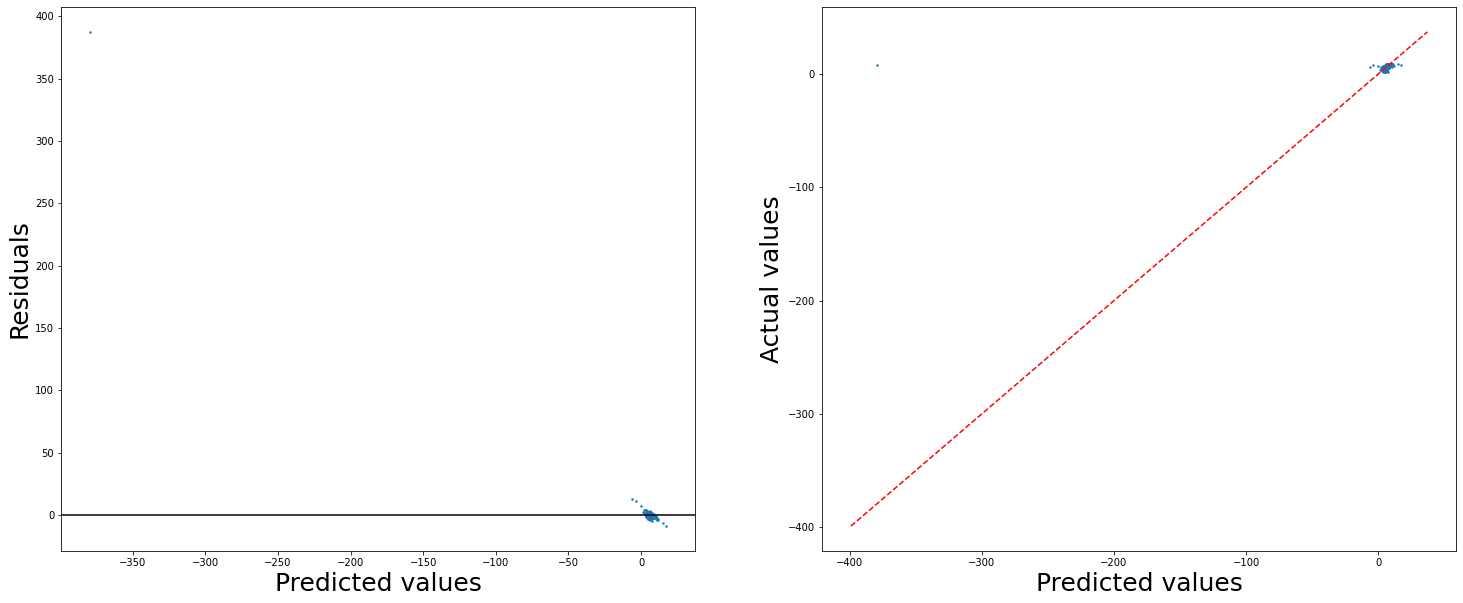

In [524]:
pr_residuals = y_test - y_pred_pr

fig, axs = plt.subplots(1, 2, figsize = (25, 10))
axs[0].scatter(y_pred_pr, pr_residuals, s = 2)
axs[0].axhline(y = 0, color = 'black')
axs[0].set_ylabel('Residuals', fontsize = 25)
axs[0].set_xlabel('Predicted values', fontsize = 25)

axs[1].scatter(y_pred_pr, y_test, s = 2)
# y = x line
x_vals = np.array(plt.gca().get_xlim())
axs[1].plot(x_vals, x_vals, '--', color = 'red', label = 'y = x')
axs[1].set_ylabel('Actual values', fontsize = 25)
axs[1].set_xlabel('Predicted values', fontsize = 25)

plt.show()

# Seems like one prediction here is very poor and this is causing the increase in MSE.
# Probably on one of the tails of the prediction curve, due to the quadratic fit.

In [525]:
# Feature names
imdb_rt.columns

Index(['title', 'netflix', 'hulu', 'prime', 'disney', 'runtime', 'num_votes',
       'rt_rating', 'drama', 'biography', 'mystery', 'sci-fi', 'music',
       'horror', 'adventure', 'crime', 'documentary', '\n', 'animation',
       'family', 'western', 'film-noir', 'musical', 'history', 'sport',
       'thriller', 'action', 'talk-show', 'news', 'comedy', 'fantasy', 'war',
       'reality-tv', 'romance', 'imdb_rating'],
      dtype='object')

In [529]:
# Lets inspect this point
X_test[np.abs(pr_residuals).argmax(), :]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 9.6000e+01,
       2.7901e+04, 7.4000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00])

In [530]:
y_test[np.abs(pr_residuals).argmax()]

array([8.2])

In [531]:
y_pred_pr[np.abs(pr_residuals).argmax()]

array([-379.27073577])

In [532]:
# Really not clear why this point has been predicted so poorly.
# Lets project our predictions onto the interval [0, 10] as it is nonsensical for
# predictions to be above or below this range anyway.
y_pred_pr[y_pred_pr < 0] = 0
y_pred_pr[y_pred_pr > 10] = 10

((y_test - y_pred_pr)**2).mean()
# Still worse than linear regression

0.7897660784716249

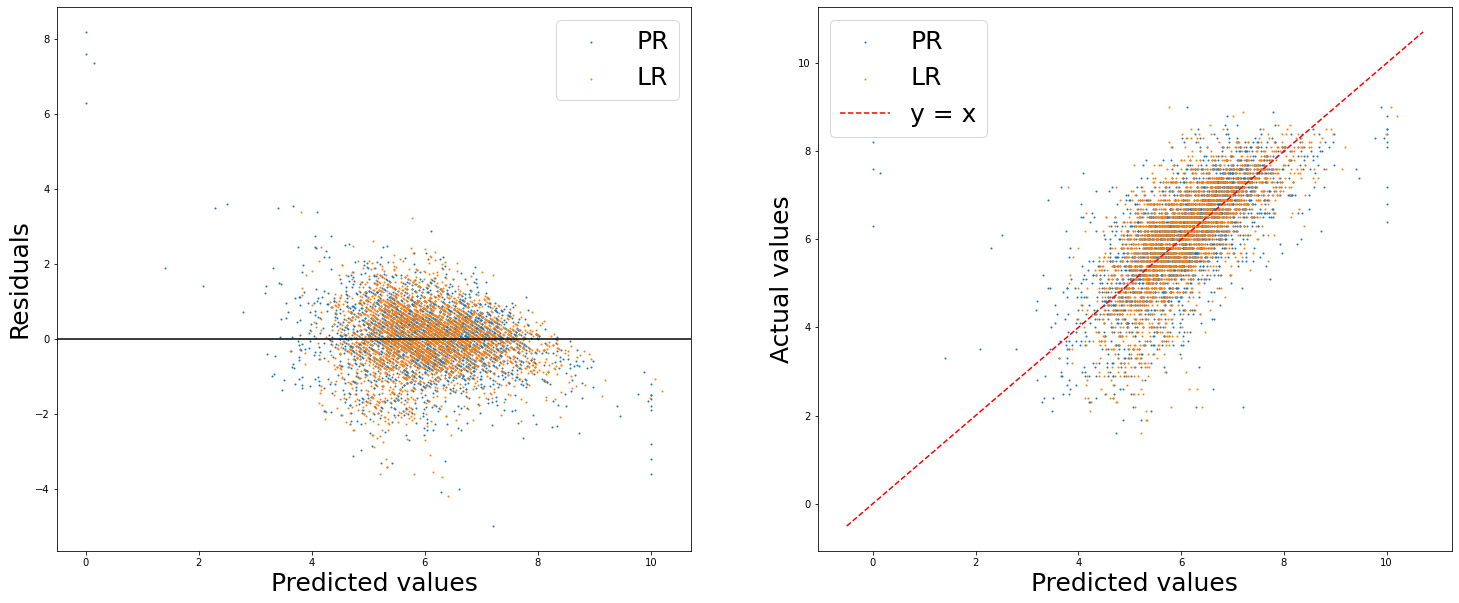

In [533]:
pr_residuals = y_test - y_pred_pr

fig, axs = plt.subplots(1, 2, figsize = (25, 10))
axs[0].scatter(y_pred_pr, pr_residuals, s = 1, label = 'PR')
axs[0].scatter(y_pred_lr, lr_residuals, s = 1, label = 'LR')
axs[0].axhline(y = 0, color = 'black')
axs[0].set_ylabel('Residuals', fontsize = 25)
axs[0].set_xlabel('Predicted values', fontsize = 25)
axs[0].legend(fontsize = 25)

axs[1].scatter(y_pred_pr, y_test, s = 1, label = 'PR')
axs[1].scatter(y_pred_lr, y_test, s = 1, label = 'LR')
# y = x line
x_vals = np.array(plt.gca().get_xlim())
axs[1].plot(x_vals, x_vals, '--', color = 'red', label = 'y = x')
axs[1].set_ylabel('Actual values', fontsize = 25)
axs[1].set_xlabel('Predicted values', fontsize = 25)
axs[1].legend(fontsize = 25)

plt.show()

# Better, hard to to tell visually if its stronger than Linear regression.
# Perhaps there is less over-prediction at low values.
# Maybe there are outliers that are playing a part here.

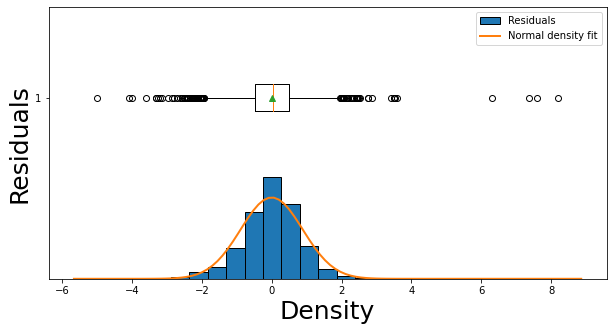

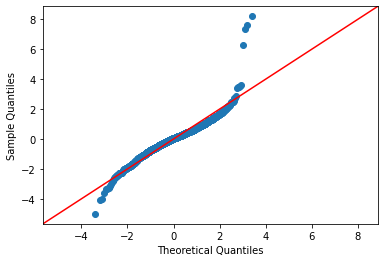

In [534]:
plt.figure(figsize = (10, 5))

plt.hist(pr_residuals, bins = 25, ec = 'black', density = True, label = 'Residuals')

x_lims = np.array(plt.gca().get_xlim())
x = np.linspace(x_lims[0], x_lims[1], 100)
p = norm.pdf(x, pr_residuals.mean(), pr_residuals.std())
plt.plot(x, p, linewidth = 2, label = 'Normal density fit')

plt.boxplot(pr_residuals, vert = False, showmeans = True, showcaps = False)

plt.ylabel('Residuals', fontsize = 25)
plt.xlabel('Density', fontsize = 25)

plt.legend()
plt.show()

sm.qqplot(pr_residuals.reshape(-1), line = '45')
pylab.show()

# Tails now seem worse and the skew hasnt been rectified

In [535]:
# Compute the 'hat' matrix and extract the leverage of each point
H = np.matmul(np.matmul(X, np.linalg.inv(np.matmul(X.T, X))), X.T)
h = np.diag(H)

In [536]:
# Mean leverage
h_mean = np.mean(h)

# If a points leverage is more than 3 times the mean leverage, that point can be considered an outlier
outliers = np.where(h > 3 * h_mean)[0]

In [537]:
# Fair few number of outliers here, lets see what effect this has
outliers

array([  41,   88,  124,  157,  184,  198,  199,  208,  215,  228,  229,
        232,  238,  244,  245,  251,  257,  279,  281,  287,  289,  297,
        307,  314,  316,  331,  811,  903, 1083, 1086, 1130, 1256, 1273,
       1292, 1363, 1373, 1447, 1515, 1575, 1647, 1707, 1714, 1796, 1821,
       2222, 2271, 2305, 2415, 2469, 2490, 2504, 2636, 2712, 2782, 2878,
       2913, 2978, 3050, 3151, 3263, 3290, 3293, 3398, 3513, 3528, 3607,
       3617, 3648, 3650, 3701, 3810, 3899, 3981, 3982, 4054, 4270, 4312,
       4633])

In [538]:
imdb_rt.iloc[outliers]
# A few films here with very large difference between the rt rating and the imdb rating, but no obvious reason these are outliers.

,title,netflix,hulu,prime,disney,runtime,num_votes,rt_rating,drama,biography,...,thriller,action,talk-show,news,comedy,fantasy,war,reality-tv,romance,imdb_rating
41,midnight1934,0,0,1,0,76.0,1007,4.7,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5
88,deadend1937,0,0,1,0,93.0,7737,6.2,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2
124,thelittleprincess1939,0,0,1,0,93.0,6214,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.1
157,meetjohndoe1941,0,0,1,0,135.0,13684,6.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.6
184,wildcat1942,0,0,1,0,70.0,117,3.8,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982,avengersendgame2019,0,0,0,1,181.0,1099508,9.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.4
4054,edison2015,0,0,1,0,113.0,31,3.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2
4270,thekid2019,0,1,0,1,100.0,8591,6.2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.9
4312,scientologythescienceoftruthortheartofdeceptio...,0,0,1,0,60.0,54,3.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2


In [539]:
# Remove outliers
mask = np.ones(X.shape[0], dtype = bool)
mask[outliers] = False
X_in = X[mask, :]
y_in = y[mask]

In [540]:
# Rerunning the code numerous times on various test and train sets behind the scenes indicates that linear and poylnomial regression are
# performing very similarly to each other, with quite a lot of variance depending upon the split of the data. 
# Lets split the data (with outliers removed) into more chunks and get a better sense of 
# their respective performance across segments of the data

# Split the data 100 times, fit each model, and compute metrics
splits = 100
skf = KFold(n_splits = splits, shuffle = True)

metrics = np.zeros((6, splits))

index = -1
for train_index, test_index in skf.split(X_in, y_in):
    index += 1
    
    # Extract current train-test split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit a linear regression model and compute metrics
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    metrics[0, index] = lr.score(X_test, y_test)
    metrics[1, index] = np.abs(y_test - y_pred_lr).mean()
    metrics[2, index] = ((y_test - y_pred_lr)**2).mean()
    
    # Fit a poylnomial regression model and compute metrics
    pr.fit(X_train, y_train)
    y_pred_pr = pr.predict(X_test)
    
    metrics[3, index] = pr.score(X_test, y_test)
    metrics[4, index] = np.abs(y_test - y_pred_pr).mean()
    metrics[5, index] = ((y_test - y_pred_pr)**2).mean()
    
    print(f'Iteration {index + 1}...\r', end = '')

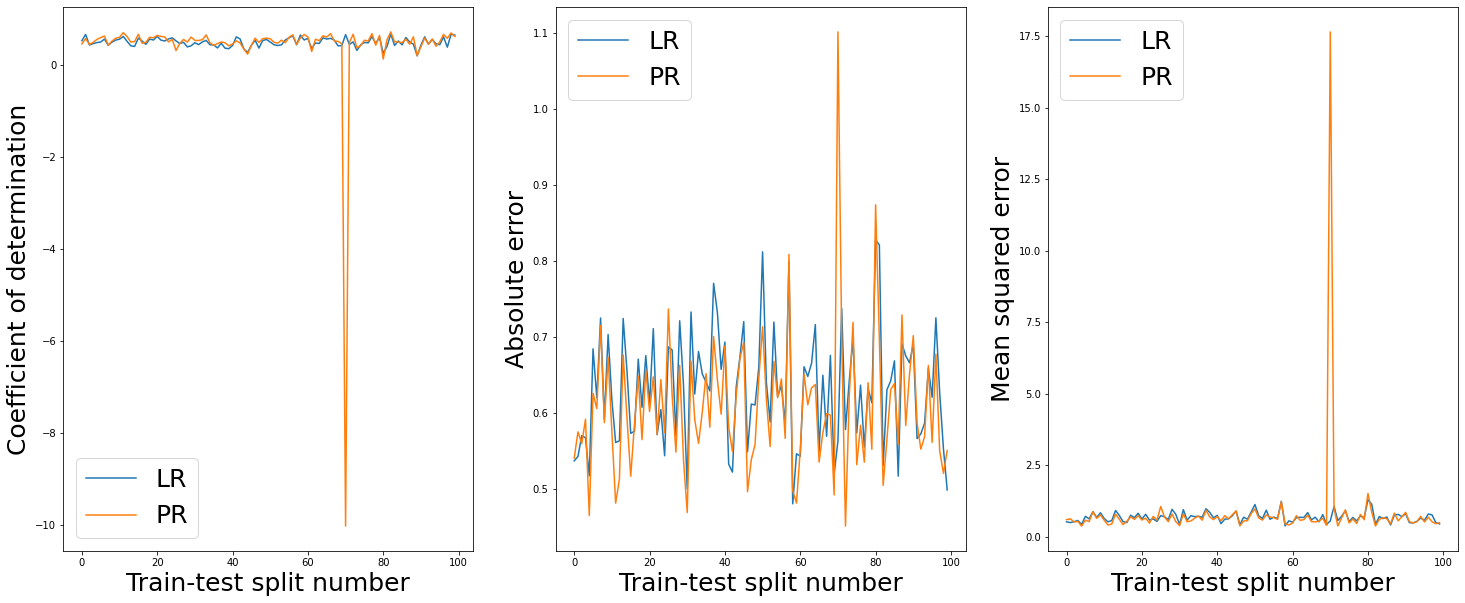

In [541]:
fig, axs = plt.subplots(1, 3, figsize = (25, 10))

axs[0].plot(metrics[0, :], label = 'LR')
axs[0].plot(metrics[3, :], label = 'PR')
axs[0].legend(fontsize = 25)
axs[0].set_xlabel('Train-test split number', fontsize = 25)
axs[0].set_ylabel('Coefficient of determination', fontsize = 25)

axs[1].plot(metrics[1, :], label = 'LR')
axs[1].plot(metrics[4, :], label = 'PR')
axs[1].legend(fontsize = 25)
axs[1].set_xlabel('Train-test split number', fontsize = 25)
axs[1].set_ylabel('Absolute error', fontsize = 25)
                  
axs[2].plot(metrics[2, :], label = 'LR')
axs[2].plot(metrics[5, :], label = 'PR')
axs[2].legend(fontsize = 25)
axs[2].set_xlabel('Train-test split number', fontsize = 25)
axs[2].set_ylabel('Mean squared error', fontsize = 25)
                  
plt.show()

# Interesting plots.
# Seem to show that Polynomial and Linear regression are performing very similarly, except that PR
# is predicting arbitrarily badly on a segment of the data. Note that our outlier detection above didnt seem to solve this.
# We could inspect this segment of the data further but it doesnt make sense to do this as LR is performing
# similarly well on all other parts of the data.

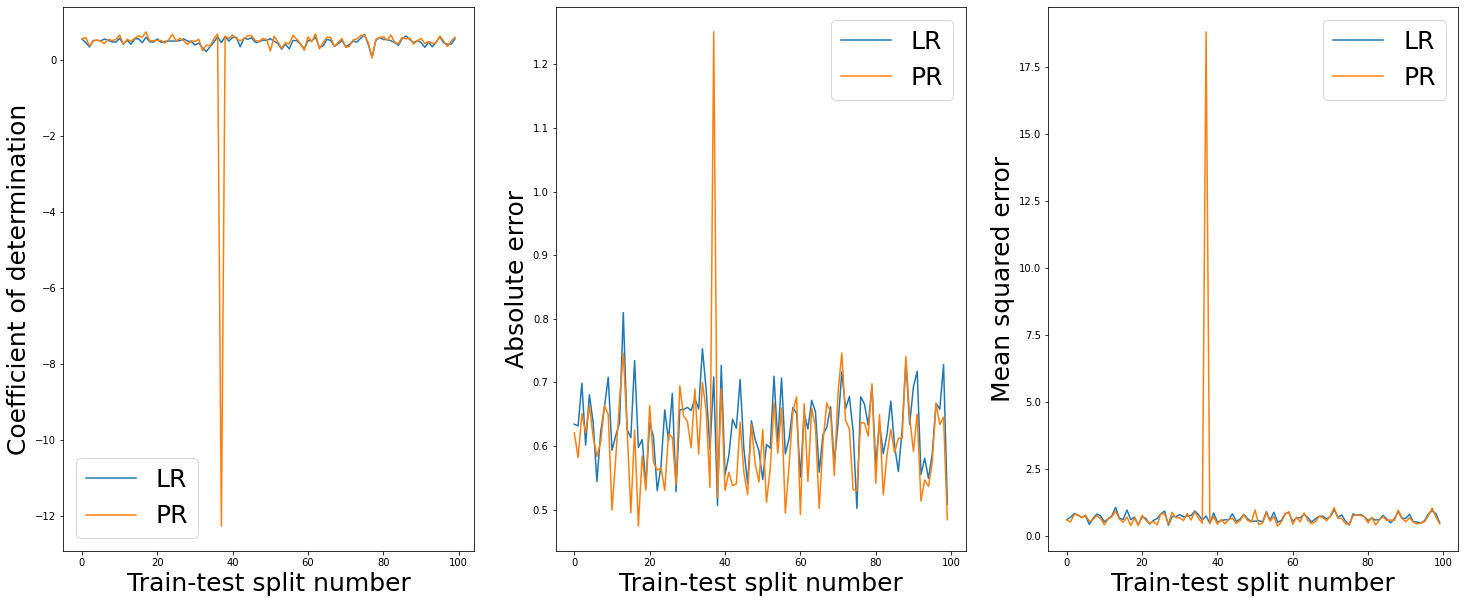

In [543]:
# Lets do the same with all of the data, outliers not removed
splits = 100
skf = KFold(n_splits = splits, shuffle = True)

metrics = np.zeros((6, splits))

index = -1
for train_index, test_index in skf.split(X_in, y_in):
    index += 1
    
    # Extract current train-test split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit a linear regression model and compute metrics
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    metrics[0, index] = lr.score(X_test, y_test)
    metrics[1, index] = np.abs(y_test - y_pred_lr).mean()
    metrics[2, index] = ((y_test - y_pred_lr)**2).mean()
    
    # Fit a poylnomial regression model and compute metrics
    pr.fit(X_train, y_train)
    y_pred_pr = pr.predict(X_test)
    
    metrics[3, index] = pr.score(X_test, y_test)
    metrics[4, index] = np.abs(y_test - y_pred_pr).mean()
    metrics[5, index] = ((y_test - y_pred_pr)**2).mean()
    
    print(f'Iteration {index + 1}...\r', end = '')
    
fig, axs = plt.subplots(1, 3, figsize = (25, 10))

axs[0].plot(metrics[0, :], label = 'LR')
axs[0].plot(metrics[3, :], label = 'PR')
axs[0].legend(fontsize = 25)
axs[0].set_xlabel('Train-test split number', fontsize = 25)
axs[0].set_ylabel('Coefficient of determination', fontsize = 25)

axs[1].plot(metrics[1, :], label = 'LR')
axs[1].plot(metrics[4, :], label = 'PR')
axs[1].legend(fontsize = 25)
axs[1].set_xlabel('Train-test split number', fontsize = 25)
axs[1].set_ylabel('Absolute error', fontsize = 25)
                  
axs[2].plot(metrics[2, :], label = 'LR')
axs[2].plot(metrics[5, :], label = 'PR')
axs[2].legend(fontsize = 25)
axs[2].set_xlabel('Train-test split number', fontsize = 25)
axs[2].set_ylabel('Mean squared error', fontsize = 25)
                  
plt.show()

# Same story...
# The analysis suggests that of the three linear models considered, linear regression is the best choice. 

## Model fit analysis

In [547]:
# Lets get a final fit on the entire data set and extract coefficients
lr.fit(X, y)

LinearRegression()

In [548]:
# Coeficient names
imdb_rt.columns[1: -1]

Index(['netflix', 'hulu', 'prime', 'disney', 'runtime', 'num_votes',
       'rt_rating', 'drama', 'biography', 'mystery', 'sci-fi', 'music',
       'horror', 'adventure', 'crime', 'documentary', '\n', 'animation',
       'family', 'western', 'film-noir', 'musical', 'history', 'sport',
       'thriller', 'action', 'talk-show', 'news', 'comedy', 'fantasy', 'war',
       'reality-tv', 'romance'],
      dtype='object')

In [549]:
# Coefficients 
lr.coef_

array([[-2.12429233e-02, -1.79496050e-01,  5.90015537e-02,
         3.58901595e-02,  7.32537646e-03,  7.21777764e-07,
         4.57056183e-01,  1.80687632e-01,  9.93487146e-04,
        -1.51831212e-01, -4.19511025e-01,  6.90447100e-02,
        -6.94088143e-01, -1.55293524e-01, -8.49508316e-02,
         1.03231113e+00,  1.36963528e+00,  2.26743258e-01,
        -8.19082606e-02,  3.59200084e-01,  4.52146722e-01,
         2.89417996e-03, -2.41831516e-02, -2.52157133e-02,
        -3.11377966e-01, -4.05739072e-01,  1.87850751e-01,
         1.09981639e-01, -2.07979047e-01, -2.36934706e-01,
        -8.06653114e-02, -3.14461584e-01, -6.69937551e-02]])

In [550]:
features = pd.DataFrame(lr.coef_)
features.columns = imdb_rt.columns[1: -1]
features

,netflix,hulu,prime,disney,runtime,num_votes,rt_rating,drama,biography,mystery,...,sport,thriller,action,talk-show,news,comedy,fantasy,war,reality-tv,romance
0,-0.021243,-0.179496,0.059002,0.03589,0.007325,7.217778e-07,0.457056,0.180688,0.000993,-0.151831,...,-0.025216,-0.311378,-0.405739,0.187851,0.109982,-0.207979,-0.236935,-0.080665,-0.314462,-0.066994


In [551]:
features.iloc[0, 0:4]
# Looks like if a film is critically scored well on hulu this actually has a relatively strong negative correlation with the user rating.
# Other platforms have minimal impact.

netflix   -0.021243
hulu      -0.179496
prime      0.059002
disney     0.035890
Name: 0, dtype: float64

In [553]:
features['num_votes']
# No (linear) correlation with the number of votes a film gets and the resulting score
# Slighlty surprising as I would expect more popular shows to be better, and get more votes

0    7.217778e-07
Name: num_votes, dtype: float64

In [557]:
features['runtime']
# Not much of a correlation between runtime and user score.

0    0.007325
Name: runtime, dtype: float64

In [558]:
features['rt_rating']
# Not surprising that the higher a show is critically rated the better the user score is, though it is interesting that
# every increase in 1 critic score is only a ~0.5 increase in user score.

0    0.457056
Name: rt_rating, dtype: float64

In [562]:
features.iloc[0, 7:33]
# A few interesting things to pick out here
# High critic reviews for horror films dont translate to high user scores, while documentaries seem to be under appreciated by critics
# The largest feature is actually associated with "/n" which translates to no genre provided by IMDB. I cant find any information
# provided by IMDB on how they make these genre assignments. 

drama          0.180688
biography      0.000993
mystery       -0.151831
sci-fi        -0.419511
music          0.069045
horror        -0.694088
adventure     -0.155294
crime         -0.084951
documentary    1.032311
\n             1.369635
animation      0.226743
family        -0.081908
western        0.359200
film-noir      0.452147
musical        0.002894
history       -0.024183
sport         -0.025216
thriller      -0.311378
action        -0.405739
talk-show      0.187851
news           0.109982
comedy        -0.207979
fantasy       -0.236935
war           -0.080665
reality-tv    -0.314462
romance       -0.066994
Name: 0, dtype: float64